# VGG16

### Loading Libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model

from glob import glob
from tqdm import tqdm

2023-09-21 09:44:22.180879: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 09:44:22.415682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 09:44:23.337734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading the Data

In [3]:
data_dir = 'lung_colon_image_set/'

folders = glob(data_dir + '*')
print(folders)

images = glob(data_dir + '*/*.jpeg')
print('No. of Images: ', len(images))

['lung_colon_image_set/colon_aca', 'lung_colon_image_set/colon_n', 'lung_colon_image_set/lung_aca', 'lung_colon_image_set/lung_n', 'lung_colon_image_set/lung_scc']
No. of Images:  25000


### Plotting Sample Data

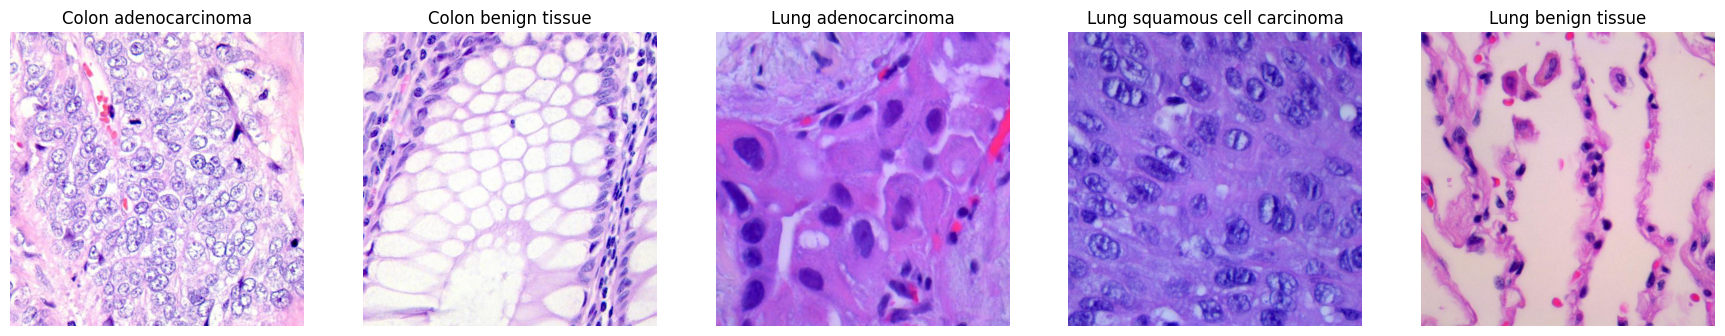

In [4]:
sample_imgs = ['lung_colon_image_set/colon_aca/colonca1.jpeg', 'lung_colon_image_set/colon_n/colonn1.jpeg', 'lung_colon_image_set/lung_aca/lungaca1.jpeg',
               'lung_colon_image_set/lung_scc/lungscc1.jpeg', 'lung_colon_image_set/lung_n/lungn1.jpeg']
titles = ['Colon adenocarcinoma', 'Colon benign tissue', 'Lung adenocarcinoma', 'Lung squamous cell carcinoma', 'Lung benign tissue']


plt.figure(figsize=(22, 8)) 
n = 1

for i in sample_imgs:
    plt.subplot(1, 5, n)
    plt.title(titles[n-1])
    plt.imshow(image.load_img(i))
    plt.axis('off')
    n += 1
plt.show()

### Splitting into Train-Test Sets

In [5]:
datagen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
    )

batch_size = 32

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


### Normalizing the Data

In [6]:
# normalization_layer = keras.layers.Rescaling(1./255)

# #normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
# normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_train_data))
# first_image = image_batch[0]

# print(np.min(first_image), np.max(first_image))

### Building the Model

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the weights of the pre-trained layers to ensure that they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Adding output layer
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2023-09-21 09:46:00.215475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 09:46:00.326845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 09:46:00.327062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Limiting GPU Memory Growth

In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Training the Model

In [12]:
train_steps_per_epoch = len(train_generator)
test_steps_per_epoch = len(test_generator)

epochs = 10

history = model.fit(
    x=train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch
)

Epoch 1/10


2023-09-21 09:50:46.931695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-21 09:50:47.431628: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-21 09:50:48.463155: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-21 09:50:48.463206: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

625/625 [==============================] - ETA: 0s - loss: 1.4304 - accuracy: 0.9362

2023-09-21 09:54:01.564607: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


625/625 [==============================] - 197s 303ms/step - loss: 1.4304 - accuracy: 0.9362 - val_loss: 0.1077 - val_accuracy: 0.9690
Epoch 2/10
625/625 [==============================] - 188s 301ms/step - loss: 0.1109 - accuracy: 0.9750 - val_loss: 0.3265 - val_accuracy: 0.9446
Epoch 3/10
625/625 [==============================] - 188s 301ms/step - loss: 0.1011 - accuracy: 0.9829 - val_loss: 0.1054 - val_accuracy: 0.9794
Epoch 4/10
625/625 [==============================] - 189s 302ms/step - loss: 0.0609 - accuracy: 0.9872 - val_loss: 0.1834 - val_accuracy: 0.9714
Epoch 5/10
625/625 [==============================] - 189s 302ms/step - loss: 0.0593 - accuracy: 0.9901 - val_loss: 0.1042 - val_accuracy: 0.9810
Epoch 6/10
625/625 [==============================] - 189s 302ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.1256 - val_accuracy: 0.9826
Epoch 7/10
625/625 [==============================] - 189s 302ms/step - loss: 0.0368 - accuracy: 0.9945 - val_loss: 0.1224 - val_accura

In [13]:
model.evaluate(test_generator)

: 